In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import multiprocessing as mp
from matplotlib import animation

## Numerical Solver 

In [2]:
"""
Numerical solver for time-stepping method, default x range: [0, 1], y range: [0, 1] default t range: [0, 10]
Boundary conditions: c(x, y = 1; t) = 1 and c(x, y = 0; t) = 0; c(x = 0, y; t) = c(x = 1, y; t), initial
conditions: c(x, y; t = 0) = 0 for 0 ≤ x ≤ 1, 0 ≤ y < 1.
"""

N = 50
mesh_x = np.linspace(0, 1, 50)

# create empty matrix to store solution of PDE
c_0 = np.zeros((N, N))
c_0[:, -1].fill(1)
print(np.shape(c_0))

(50, 50)


### Jacobi iteration

In [3]:

def Jacobi_solver(n_i, c_):

    c = np.copy(c_)

    for j in range(n_i-2):
        j += 1
        for i in range(n_i):

            # boundary conditions
            if i == 0:
                c_ = 1/4 * (c[i+1, j] + c[-1, j] + c[i, j+1] + c[i, j-1])
            elif i == n_i-1:
                c_ = 1/4 * (c[1, j] + c[i-1, j] + c[i, j+1] + c[i, j-1])
                
            else:
                c_ = 1/4 * (c[i+1, j] + c[i-1, j] + c[i, j+1] + c[i, j-1])

            c[i, j] = c_

    return c

### Gauss-Seidel iteration

In [4]:

# Take the grid point i, j and the matrix for current iteration and last iteration as input
def Gauss_Seidel_solver(i, j, n_i, c_k, c_k_1):

    # boundary conditions
    if i == 0:
        c_new = 1/4 * (c_k[i+1, j] + c_k_1[-1, j] + c_k[i, j+1] + c_k_1[i, j-1])
    elif i == n_i-1:
        c_new = 1/4 * (c_k[0, j] + c_k_1[i-1, j] + c_k[i, j+1] + c_k_1[i, j-1])
        
    else:
        c_new = 1/4 * (c_k[i+1, j] + c_k_1[i-1, j] + c_k[i, j+1] + c_k_1[i, j-1])

    return c_new

### Successive Over Relaxation

In [5]:
def SOR_solver(i, j, n_i, c_k, c_k_1, w=1.8):

    # boundary conditions
    if i == 0:
        c_new = w/4 * (c_k[i+1, j] + c_k_1[-1, j] + c_k[i, j+1] + c_k_1[i, j-1]) + (1-w) * c_k[i, j]
    elif i == n_i-1:
        c_new = w/4 * (c_k[0, j] + c_k_1[i-1, j] + c_k[i, j+1] + c_k_1[i, j-1]) + (1-w) * c_k[i, j]
        
    else:
        c_new = w/4 * (c_k[i+1, j] + c_k_1[i-1, j] + c_k[i, j+1] + c_k_1[i, j-1]) + (1-w) * c_k[i, j]

    return c_new

## Implement

### Jacobi

In [6]:

max_ite = 5000

c_store_J = np.zeros((max_ite+1, N, N))
c_store_J[:, :, -1].fill(1)

# Store the convergence measure delta
delta_j = np.zeros(max_ite+1)

e = 1e-5

if __name__ == '__main__':

    c_copy = np.zeros((N, N))
    c_copy[:, -1].fill(1)
    
    for k in range(max_ite):

        c_j = Jacobi_solver(n_i=N, c_=c_copy)
        c_store_J[k+1, :, :] = c_j

        diff_j = c_j - c_copy
        delta_j[k] = abs(max(diff_j.max(), diff_j.min(), key=abs))

        if delta_j[k] < e:
            print(k)
            break

        c_copy = c_j
              

2383


### Gauss_Seidel

In [7]:
max_ite = 5000

c_store_g = np.zeros((max_ite+1, N, N))
c_store_g[:, :, -1].fill(1)

# Store the convergence measure delta
delta_g = np.zeros(max_ite+1)

e = 1e-5

if __name__ == '__main__':

    c_keep = np.zeros((N, N))
    c_keep[:, -1].fill(1)

    c_g = np.zeros((N, N))
    c_g[:, -1].fill(1)
    
    for k in range(max_ite):
        for j in range(N-2):
            j += 1
            for i in range(N):
                # Compute the c_i_j^k+1
                c_g[i, j] = Gauss_Seidel_solver(i, j, n_i=N, c_k=c_keep, c_k_1=c_g)
        
        c_store_g[k+1, :, :] = c_g
        
        diff_g = c_g - c_keep
        delta_g[k] = abs(max(diff_g.max(), diff_g.min(), key=abs))

        if delta_g[k] < e:
            print(k)
            break

        c_keep = np.copy(c_g)

2406


### Successive Over Relaxation (SOR)

#### Object detector

In [6]:
def object_detector(i, j, num=0, length=0, lower_bound=0, upper_bound=1):
    num = num 
    l = length
    passcheck = 0

    a1 = (1-l)/2
    b1 = (1+l)/2

    a2 = (1-2*l)/3
    a3 = (2-l)/3
    b2 = (1+l)/3
    b3 = (2+2*l)/3

    if num == 1:
        if ((j > a1) and (j < b1)) and ((i > a1) and (i < b1)):
            passcheck = 1

    if num == 2:
        if ((j > a1) and (j < b1)) and \
            (((i > a2) and (i < b2)) or ((i > a3) and (i < b3))):
            passcheck = 1

    if num == 4:
        if (((j > a2) and (j < b2)) or ((j > a3) and (j < b3))) and \
            (((i > a2) and (i < b2)) or ((i > a3) and (i < b3))):
            passcheck = 1
    
    return passcheck


In [13]:
def implement_sor(max_ite=5000, w=1.8, e=1e-5, N=100, num=0, length=0):
    ##########################################################
    # Initialize valuse
    max_ite = max_ite
    e = e
    delta_x = 1 / N
    # check the number of sinks
    num = num
    if num == 3 or num > 4:
        print('num can only take value 1, 2 or 4!')
        return None
    ###########################################################
    # Create tracker matrix
    c_store_s = np.zeros((max_ite+1, N, N))
    c_store_s[:, :, -1].fill(1)

    # Store the convergence measure delta
    delta_s = np.zeros(max_ite+1)

    # create matrix to store function value at the last step
    c_keep_s = np.zeros((N, N))
    c_keep_s[:, -1].fill(1)

    # Create matrix to store function value at the current step
    c_s = np.zeros((N, N))
    c_s[:, -1].fill(1)
    ##################################################################################
    # apply the sor method (pity that I don't know how to enable parellel computing :( )
    for k in range(max_ite):
        for j in range(N-2):
            j += 1
            for i in range(N):
                ####################################################################          
                # Check if the point (i,j) lies within the sink!
                passcheck = object_detector(i=i*delta_x, j=j*delta_x, num=num, length=length)
                if passcheck == 0:
                    c_s[i, j] = SOR_solver(i, j, n_i=N, c_k=c_keep_s, c_k_1=c_s, w=w)
                else:
                    c_s[i, j] = 0
                ####################################################################
        
        # Update the tracker
        c_store_s[k+1, :, :] = c_s
        
        # apply the threshold
        diff_s = c_s - c_keep_s
        delta_s[k] = abs(max(diff_s.max(), diff_s.min(), key=abs))
        
        if delta_s[k] < e:
            break

        # update the store matrix
        c_keep_s = np.copy(c_s)
    #####################################################################################

    return c_store_s, delta_s, k


In [15]:
%%time
if __name__ == '__main__':
    c_store_s, delta_s, k_s = implement_sor(w=1.8, N=150)
print(k_s)

2528
Wall time: 1min 31s


## Plot

### 1.

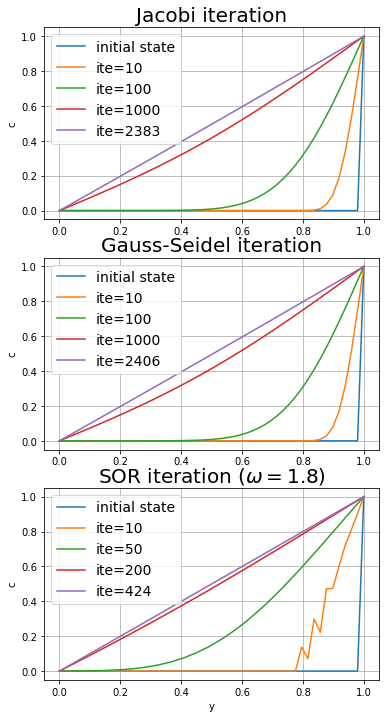

In [11]:
N = 50
y_plot = np.linspace(0, 1, N)

plt.rcParams['figure.figsize'] = (6, 12)

fig1, ax1 = plt.subplots(3,1)

plot_j = [10, 100, 1000, 2383]
plot_g = [10, 100, 1000, 2406]
plot_sor = [10, 50, 200, 424]

ax1[0].plot(y_plot, c_store_J[0, 0, :], label='initial state')
ax1[1].plot(y_plot, c_store_g[0, 0, :], label='initial state')
ax1[2].plot(y_plot, c_store_s[0, 0, :], label='initial state')

for i in plot_j:
    ax1[0].plot(y_plot, c_store_J[i+1, 0, :], label='ite=%i' % i)
ax1[0].legend(fontsize=14)

for j in plot_g:
    ax1[1].plot(y_plot, c_store_g[j+1, 0, :], label='ite=%i' % j)
ax1[1].legend(fontsize=14)

for k in plot_sor:
    ax1[2].plot(y_plot, c_store_s[k+1, 0, :], label='ite=%i' % k)
ax1[2].legend(fontsize=14)

ax1[0].set_title('Jacobi iteration', fontsize=20)
ax1[1].set_title('Gauss-Seidel iteration', fontsize=20)
ax1[2].set_title(r'SOR iteration ($\omega=1.8$)', fontsize=20)

ax1[0].set(ylabel='c')
ax1[1].set(ylabel='c')
ax1[2].set(xlabel='y', ylabel='c')

ax1[0].grid(visible=True)
ax1[1].grid(visible=True)
ax1[2].grid(visible=True)
plt.show()

### Experiment SOR with different w

In [12]:
max_ite = 5000

delta_w = 0.05
w_value = np.linspace(1, 2, int(1/delta_w), endpoint=False)
delta_sw_store = np.zeros((len(w_value), max_ite+1))

if __name__ == '__main__':

    k_store = []

    for iteration, w in enumerate(w_value):
        c_store_w, delta_s_w, k_w = implement_sor(w=w)
        k_store.append(k)
        print(k_w, end=',')

        # Store the convergency measures for each w value
        delta_sw_store[iteration, :] = delta_s_w


KeyboardInterrupt: 

### Convergency measure vs. iteration number

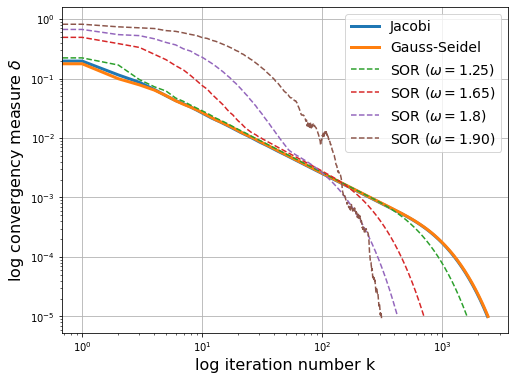

In [ ]:
delta_j_p = delta_j[:2384]
delta_g_p = delta_g[:2407]
delta_s_p = delta_s[:425]

plt.rcParams['figure.figsize'] = (8, 6)

fig2, ax2 = plt.subplots(1)

x_label = 'log iteration number k'
y_label = r'log convergency measure $\delta$'

ax2.loglog(np.arange(2384), delta_j_p, label='Jacobi', lw=3)
ax2.loglog(np.arange(2407), delta_g_p, label='Gauss-Seidel', lw=3)
ax2.loglog(np.arange(1610), delta_sw_store[5, :1610], '--', label=r'SOR ($\omega=1.25$)')
ax2.loglog(np.arange(705), delta_sw_store[13, :705], '--', label=r'SOR ($\omega=1.65$)')
ax2.loglog(np.arange(425), delta_s_p, '--', label=r'SOR ($\omega=1.8$)')
ax2.loglog(np.arange(313), delta_sw_store[18, :313], '--', label=r'SOR ($\omega=1.90$)')

ax2.set(xlabel=x_label, ylabel=y_label)
ax2.xaxis.label.set_size(16)
ax2.yaxis.label.set_size(16)

ax2.legend(fontsize=14, loc='upper right')

ax2.grid(visible=True)
plt.show()


## Find the optimal w, using bisection method

### Define optimizor

In [ ]:
def optimize_sor(lower_bound=1.7, upper_bound=2, N=50, max_ite=5000, e=1e-5, num=0, length=0):
    a = lower_bound
    b = upper_bound
    check = 0
    
    for k in range(max_ite):

        # Calculate the midpoint
        c = (a + b) / 2

        convergency_l = implement_sor(max_ite=max_ite, w=a, e=e, N=N, num=num, length=length)

        # We dont really need the upper bound function value
        # Since we have prior knowledge of the interval we are studying

        # convergency_u = implement_sor(max_ite=max_ite, w=b, e=e, N=N)
        convergency_m = implement_sor(max_ite=max_ite, w=c, e=e, N=N, num=num, length=length)

        k_l = convergency_l[2]
        # k_u = convergency_u[2]
        k_m = convergency_m[2]

        # Apply the secant method
        if k_m < k_l:
            a = c
        if k_m > k_l:
            b = c

        # Check if midpoint and lower bound by chance lie symmetriclly
        if k_m == k_l:
            check += 1
        if check == 2:
            print(convergency_m[2], end=',')
            break

        if k == max_ite-1:
            print('Failed to find the optimal solution in the max iteration steps!')
    
    return convergency_m[2], c

### Optimize with different N

In [ ]:
def optimize_experiment(lower_bound=10, upper_bound=100, n_interval=10, num=0, length=0):
    N_value = np.linspace(lower_bound, upper_bound, n_interval)
    optimal_step = np.zeros(len(N_value))
    optimal_w = np.zeros(len(N_value))

    for i, n in enumerate(N_value):
        optimal = optimize_sor(N=int(n), num=num, length=length)
        optimal_w[i] = optimal[1]
        optimal_step[i] = optimal[0]
    
    return N_value, optimal_w, optimal_step

In [ ]:
if __name__ == '__main__':
    N_optimal_plot, optimal_w, optimal_step = optimize_experiment(lower_bound=10, upper_bound=100, n_interval=20, num=0)
    print(optimal_w, '\n', optimal_step)

90,72,100,128,213,176,206,254,250,284,307,338,520,423,428,432,452,504,504,544,[1.70117188 1.70117188 1.77529297 1.803125   1.85014648 1.85029297
 1.86171875 1.88764648 1.88779297 1.8921875  1.90632324 1.90683594
 1.92507324 1.92514648 1.92529297 1.92734375 1.93027344 1.93466797
 1.93671875 1.93701172] 
 [ 90.  72. 100. 128. 213. 176. 206. 254. 250. 284. 307. 338. 520. 423.
 428. 432. 452. 504. 504. 544.]


### Plot optimal w vs. N

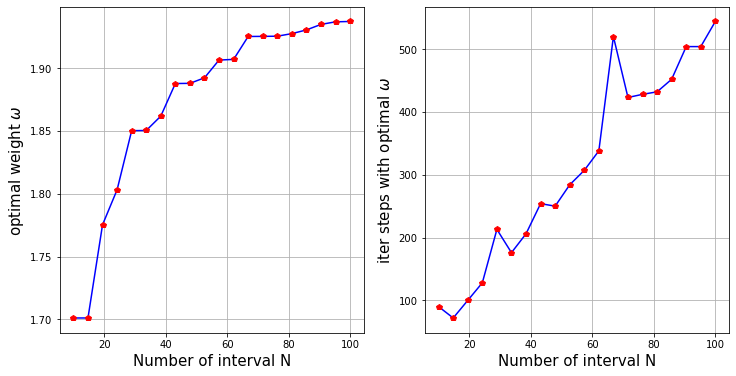

In [ ]:
fig5, ax5 = plt.subplots(1, 2)

plt.rcParams['figure.figsize'] = (12, 6)

ax5[0].plot(N_optimal_plot, optimal_w, 'b')
ax5[0].plot(N_optimal_plot, optimal_w, 'rp')
ax5[0].set(xlabel='Number of interval N', ylabel=r'optimal weight $\omega$')
ax5[0].xaxis.label.set_size(15)
ax5[0].yaxis.label.set_size(15)

ax5[1].plot(N_optimal_plot, optimal_step, 'b')
ax5[1].plot(N_optimal_plot, optimal_step, 'rp')
ax5[1].set(xlabel='Number of interval N', ylabel=r'iter steps with optimal $\omega$')
ax5[1].xaxis.label.set_size(15)
ax5[1].yaxis.label.set_size(15)

ax5[0].grid(visible=True)
ax5[1].grid(visible=True)
plt.show()

### Assume w = a * log(N) + b, ite = c * N + d

In [ ]:
N_value = np.linspace(10, 100, 20)
print(N_value)

a, b = np.polyfit(np.log(N_value), optimal_w, 2)
c, d = np.polyfit(N_value, optimal_step, 1)

x_p = np.linspace(10, 100, 90)
y_w = a*np.log(x_p) + b
y_step = c*x_p + d

fig6, ax6 = plt.subplots(1, 2)

plt.rcParams['figure.figsize'] = (12, 6)

ax6[0].plot(N_value, optimal_w)
ax6[0].plot(x_p, y_w)
ax6[0].set(xlabel='Number of interval N', ylabel=r'optimal weight $\omega$')
ax6[0].xaxis.label.set_size(15)
ax6[0].yaxis.label.set_size(15)

ax6[1].plot(N_value, optimal_step)
ax6[1].plot(x_p, y_step)
ax6[1].set(xlabel='Number of interval N', ylabel=r'iter steps with optimal $\omega$')
ax6[1].xaxis.label.set_size(15)
ax6[1].yaxis.label.set_size(15)

ax6[0].grid(visible=True)
ax6[1].grid(visible=True)

plt.show()

[ 10.          14.73684211  19.47368421  24.21052632  28.94736842
  33.68421053  38.42105263  43.15789474  47.89473684  52.63157895
  57.36842105  62.10526316  66.84210526  71.57894737  76.31578947
  81.05263158  85.78947368  90.52631579  95.26315789 100.        ]


NameError: name 'optimal_w' is not defined

## Experiments with sinks (1, 2, 4)

In [ ]:
c_store_s_s, delta_s_s, k_s = implement_sor(num=1, length=0.25)
c_store_s_s2, delta_s_s2, k_s2 = implement_sor(num=2, length=0.25)
print(k_s, k_s2)

212 111


#### Contour plot

Locator attempting to generate 1001 ticks ([0.0, ..., 1.0]), which exceeds Locator.MAXTICKS (1000).


Text(0.5, 0, 'x')

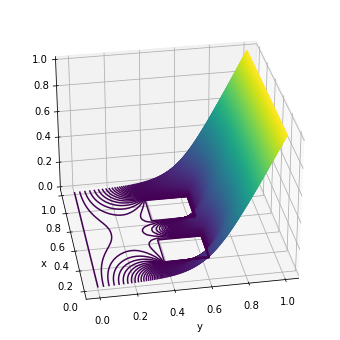

In [ ]:
ax3d = plt.axes(projection='3d')

x = np.linspace(0, 1, 50)
y = np.linspace(0, 1, 50)
X, Y = np.meshgrid(x, y)

ax3d.contour3D(X, Y, c_store_s_s2[111, :, :], 999)
ax3d.view_init(30, -100)
ax3d.set_xlabel('y')
ax3d.set_ylabel('x')

In [ ]:
l = 0.25
if __name__ == '__main__':
    N_1, opt_w_1, opt_step_1 = optimize_experiment(lower_bound=1, upper_bound=100, n_interval=20, num=1, length=l)
    print('\n')
    N_2, opt_w_2, opt_step_2 = optimize_experiment(lower_bound=1, upper_bound=100, n_interval=20, num=2, length=l)
    print('\n')
    N_4, opt_w_4, opt_step_4 = optimize_experiment(lower_bound=1, upper_bound=100, n_interval=20, num=4, length=l)
    print('\n')

print(opt_w_1, '\n', opt_step_1)
print(opt_w_2, '\n', opt_step_2)
print(opt_w_4, '\n', opt_step_4)


0,123,65,67,71,93,112,145,143,157,173,199,209,225,250,261,378,313,320,333,

0,73,72,56,62,62,76,86,94,101,141,144,145,148,160,172,184,205,203,211,

0,86,91,53,61,57,64,72,81,91,93,103,144,141,149,148,176,151,159,176,

[1.85       1.70029297 1.70234375 1.70234375 1.7375     1.78444824
 1.81308594 1.85014648 1.85029297 1.859375   1.86992188 1.88779297
 1.88867188 1.89248047 1.90683594 1.90683594 1.92503662 1.92514648
 1.92558594 1.92507324] 
 [  0. 123.  65.  67.  71.  93. 112. 145. 143. 157. 173. 199. 209. 225.
 250. 261. 378. 313. 320. 333.]
[1.85       1.70058594 1.70058594 1.70007324 1.70234375 1.71054688
 1.73984375 1.77734375 1.77734375 1.7984375  1.85000458 1.85029297
 1.85000916 1.85058594 1.86054688 1.86933594 1.86992188 1.88753662
 1.88764648 1.88808594] 
 [  0.  73.  72.  56.  62.  62.  76.  86.  94. 101. 141. 144. 145. 148.
 160. 172. 184. 205. 203. 211.]
[1.85       1.70058594 1.70058594 1.70117188 1.70117188 1.70234375
 1.7046875  1.73984375 1.71992188 1.77529297 1.77734375

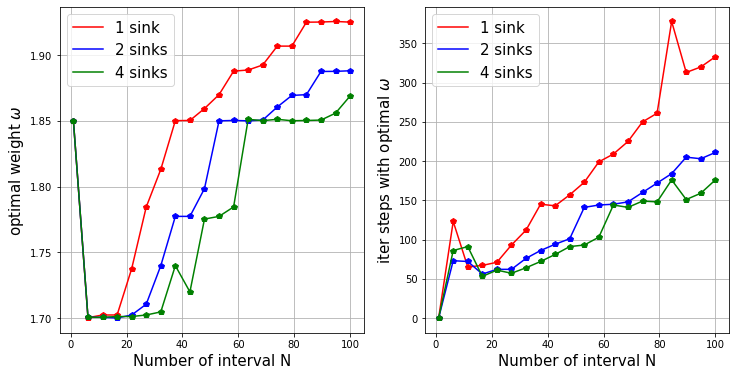

In [ ]:
N_value = np.linspace(1, 100, 20)

fig6, ax7 = plt.subplots(1, 2)
plt.rcParams['figure.figsize'] = (12, 6)

ax7[0].plot(N_value, opt_w_1, 'r', label='1 sink')
ax7[0].plot(N_value, opt_w_1, 'rp')
ax7[0].plot(N_value, opt_w_2, 'b', label='2 sinks')
ax7[0].plot(N_value, opt_w_2, 'bp')
ax7[0].plot(N_value, opt_w_4, 'g', label='4 sinks')
ax7[0].plot(N_value, opt_w_4, 'gp')

ax7[0].set(xlabel='Number of interval N', ylabel=r'optimal weight $\omega$')
ax7[0].xaxis.label.set_size(15)
ax7[0].yaxis.label.set_size(15)
ax7[0].legend(fontsize=15)

ax7[1].plot(N_value, opt_step_1, 'r', label='1 sink')
ax7[1].plot(N_value, opt_step_1, 'rp')
ax7[1].plot(N_value, opt_step_2, 'b', label='2 sinks')
ax7[1].plot(N_value, opt_step_2, 'bp')
ax7[1].plot(N_value, opt_step_4, 'g', label='4 sinks')
ax7[1].plot(N_value, opt_step_4, 'gp')

ax7[1].set(xlabel='Number of interval N', ylabel=r'iter steps with optimal $\omega$')
ax7[1].xaxis.label.set_size(15)
ax7[1].yaxis.label.set_size(15)
ax7[1].legend(fontsize=15)

ax7[0].grid(visible=True)
ax7[1].grid(visible=True)
plt.show()

## Bonus exercise: incorporate objects with insulating material

###  Insulating material

In [ ]:
def SOR_solver_insul_obj(i, j, n_i, c_k, c_k_1, length, delta_x, w=1.8):

    l = length
    a1 = (1-l)/2
    b1 = (1+l)/2

    i_bl = i+1
    i_bu = i-1
    j_bl = j+1
    j_bu = j-1

    a1_x = a1/delta_x
    b1_x = b1/delta_x

    if j > a1_x and j < b1_x:
        if i < a1_x and i > a1_x-1:
            i_bl = int(np.floor(b1_x))+1
        elif i > b1_x and i < b1_x+1:
            i_bu = int(np.floor(a1_x))

    if i > a1_x and i < b1_x:
        if j < a1_x and j > a1_x-1:
            j_bl = int(np.floor(b1_x))+1
        elif j > b1_x and j < b1_x+1:
            j_bu = int(np.floor(a1_x))
    
    # boundary conditions
    if i == 0:
        c_new = w/4 * (c_k[i+1, j] + c_k_1[-1, j] + c_k[i, j+1] + c_k_1[i, j-1]) + (1-w) * c_k[i, j]
    elif i == n_i-1:
        c_new = w/4 * (c_k[0, j] + c_k_1[i-1, j] + c_k[i, j+1] + c_k_1[i, j-1]) + (1-w) * c_k[i, j]
        
    else:
        c_new = w/4 * (c_k[i_bl, j] + c_k_1[i_bu, j] + c_k[i, j_bl] + c_k_1[i, j_bu]) + (1-w) * c_k[i, j]

    return c_new

In [ ]:
def implement_sor_insul(max_ite=5000, w=1.8, e=1e-5, N=50, num=0, length=0):
    ##########################################################
    # Initialize valuse
    max_ite = max_ite
    e = e
    delta_x = 1 / N
    # check the number of sinks
    num = num
    if num == 3 or num > 4:
        print('num can only take value 1, 2 or 4!')
        return None
    ###########################################################
    l = length

    # Create tracker matrix
    c_store_s = np.zeros((max_ite+1, N, N))
    c_store_s[:, :, -1].fill(1)

    # Store the convergence measure delta
    delta_s = np.zeros(max_ite+1)

    # create matrix to store function value at the previous step
    c_keep_s = np.zeros((N, N))
    c_keep_s[:, -1].fill(1)

    # Create matrix to store function value at the current step
    c_s = np.zeros((N, N))
    c_s[:, -1].fill(1)
    ##################################################################################
    # apply the sor method (pity that I don't know how to enable parellel computing :( )
    
  
    for k in range(max_ite):
        for j in range(N-2):
            j += 1
            for i in range(N):
                ####################################################################          
                # Check if the point (i,j) lies within the sink!
                passcheck = object_detector(i=i*delta_x, j=j*delta_x, num=num, length=length)
                if passcheck == 0:
                    c_s[i, j] = SOR_solver_insul_obj(i, j, n_i=N, c_k=c_keep_s, c_k_1=c_s, w=w, length=l, delta_x=delta_x)
                else:
                    c_s[i, j] = 0
                ####################################################################
    
        # Update the tracker
        c_store_s[k+1, :, :] = c_s
        
        # apply the threshold
        diff_s = c_s - c_keep_s
        delta_s[k] = max(diff_s.max(), diff_s.min(), key=abs)

        if delta_s[k] < e:
            break

        # update the store matrix
        c_keep_s = np.copy(c_s)
    #####################################################################################

    return c_store_s, delta_s, k


In [ ]:
c_store_s_s, delta_s_s, k_s = implement_sor_insul(num=1, length=0.5)
print(k_s)

382


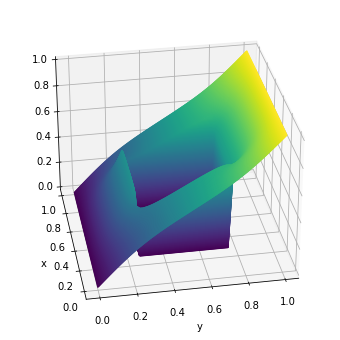

In [ ]:
axt = plt.axes(projection='3d')

plt.rcParams['figure.figsize'] = (8, 6)

x = np.linspace(0, 1, 50)
y = np.linspace(0, 1, 50)
X, Y = np.meshgrid(x, y)

axt.contour3D(X, Y, c_store_s_s[383, :, :], 500)
axt.set_xlabel('y')
axt.set_ylabel('x')
axt.view_init(30, -100)

### Define optimizor

In [ ]:
def optimize_sor_insul(lower_bound=1.7, upper_bound=2, N=50, max_ite=5000, e=1e-5, num=0, length=0):
    a = lower_bound
    b = upper_bound
    check = 0
    
    for k in range(max_ite):

        # Calculate the midpoint
        c = (a + b) / 2

        convergency_l = implement_sor_insul(max_ite=max_ite, w=a, e=e, N=N, num=num, length=length)

        # We dont really need the upper bound function value
        # Since we have prior knowledge of the interval we are studying

        # convergency_u = implement_sor(max_ite=max_ite, w=b, e=e, N=N)
        convergency_m = implement_sor_insul(max_ite=max_ite, w=c, e=e, N=N, num=num, length=length)

        k_l = convergency_l[2]
        # k_u = convergency_u[2]
        k_m = convergency_m[2]

        # Apply the secant method
        if k_m < k_l:
            a = c
        if k_m > k_l:
            b = c

        # Check if midpoint and lower bound by chance lie symmetriclly
        if k_m == k_l:
            check += 1
        if check == 2:
            print(convergency_m[2], end=',')
            break

        if k == max_ite-1:
            print('Failed to find the optimal solution in the max iteration steps!')
    
    return convergency_m[2], c

In [ ]:
def optimize_experiment_insul(lower_bound=10, upper_bound=100, n_interval=10, num=0, length=0):
    N_value = np.linspace(lower_bound, upper_bound, n_interval)
    optimal_step = np.zeros(len(N_value))
    optimal_w = np.zeros(len(N_value))

    for i, n in enumerate(N_value):
        optimal = optimize_sor_insul(N=int(n), num=num, length=length)
        optimal_w[i] = optimal[1]
        optimal_step[i] = optimal[0]
    
    return N_value, optimal_w, optimal_step

In [ ]:
l = 0.25
if __name__ == '__main__':
    N_i, opt_w_i, opt_step_i = optimize_experiment_insul(lower_bound=1, upper_bound=100, n_interval=20, num=1, length=l)

0,4,10,6,13,15,12,23,26,29,38,41,46,42,45,58,53,55,58,74,

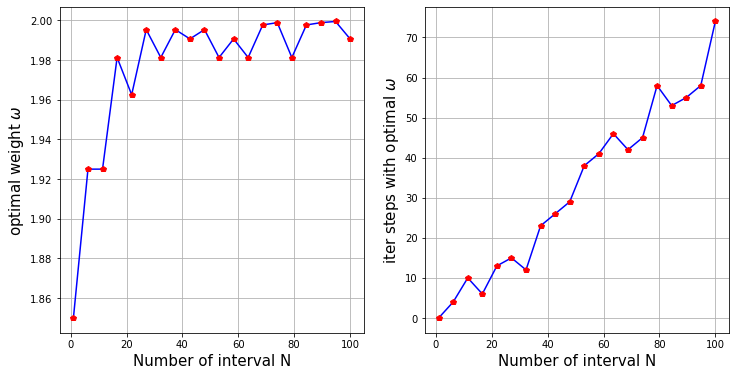

In [ ]:
fig5, ax5 = plt.subplots(1, 2)

plt.rcParams['figure.figsize'] = (12, 6)

ax5[0].plot(N_i, opt_w_i, 'b')
ax5[0].plot(N_i, opt_w_i, 'rp')
ax5[0].set(xlabel='Number of interval N', ylabel=r'optimal weight $\omega$')
ax5[0].xaxis.label.set_size(15)
ax5[0].yaxis.label.set_size(15)

ax5[1].plot(N_i, opt_step_i, 'b')
ax5[1].plot(N_i, opt_step_i, 'rp')
ax5[1].set(xlabel='Number of interval N', ylabel=r'iter steps with optimal $\omega$')
ax5[1].xaxis.label.set_size(15)
ax5[1].yaxis.label.set_size(15)

ax5[0].grid()
ax5[1].grid()
plt.show()